# 2024 Exam

In the deep learning part, you will build a neural network to classify images of trash.

You will work with a dataset of about 4,752 color images of waste items in 524x524 resolution. The dataset contains nine sub-directories, one per class:

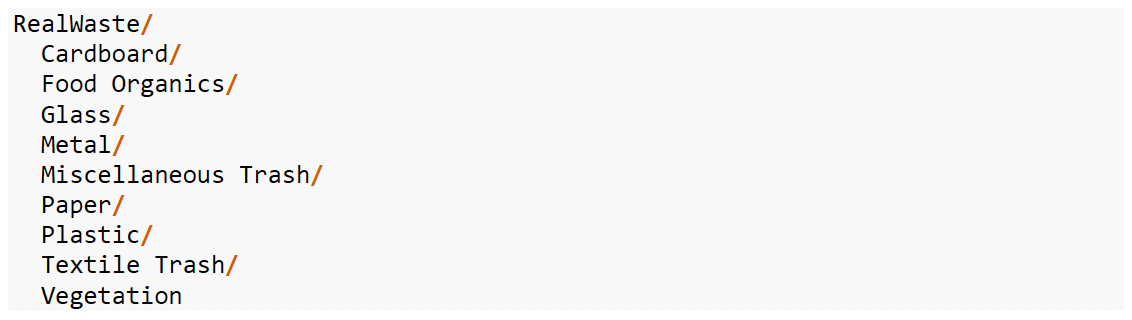

You can find more information on the dataset on https://archive.ics.uci.edu/dataset/908/realwaste. The dataset is presented and used in this research paper: https://www.mdpi.com/2078-2489/14/12/633 by Single et al. (2023).

In [ ]:
# importing the dataset

# loading libraries
import requests 
import zipfile 
import os 

# setting the current working directory
current_dir = os.getcwd()

# setting the URL of the dataset 
url = 'https://archive.ics.uci.edu/static/public/908/realwaste.zip' 

# setting the path to save the downloaded ZIP file 
zip_path = os.path.join(current_dir, 'realwaste.zip')

# downloading the ZIP file 
print("Downloading the dataset...") 
r = requests.get(url, allow_redirects=True) 
with open(zip_path, 'wb') as zip_file: 
    zip_file.write(r.content) 

# extracting the ZIP file 
print("Extracting the dataset...") 
with zipfile.ZipFile(zip_path, 'r') as zip_ref: 
    zip_ref.extractall(current_dir) 

# cleaning up the ZIP file 
os.remove(zip_path)

In [ ]:
# checking the contents of the dataset

# loading libraries
from PIL import Image 
import os 

# setting the current working directory
current_dir = os.getcwd()

# setting the path to an image in your dataset (adjust the path as necessary) 
image_path = os.path.join(current_dir, 'realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg') 

# loading the image 
image = Image.open(image_path) 

# printing the size of the image 
print(f"The image dimensions are: {image.size} (width x height)") 

# checking the mode (e.g., RGB, RGBA, L (grayscale)) 
print(f"The image mode is: {image.mode}")

The article mentions that the dataset has been scaled to 524 × 524 image resolutions to better distinguish the finer object features and reach better classification accuracies.
The model dimensions are indeed 524x524, and the image mode/format is RGB (red-green-blue), meaning that these images have three color channels.
This information will later influence the specifications of the models. 

In [ ]:
# displaying how many images are in the dataset

# setting the path to the dataset
dataset_path = os.path.join(current_dir, 'realwaste-main/RealWaste')

# initializing the count of images
image_count = 0

# looping through the folders in the dataset
for folder in os.listdir(dataset_path):
    # setting the path to the current folder
    folder_path = os.path.join(dataset_path, folder)
    # checking if the current folder is a directory
    if os.path.isdir(folder_path):
        # counting the number of files in the current folder
        image_count += len(os.listdir(folder_path))

# printing the total number of images
print(f"The dataset contains {image_count} images")

The dataset contains 4752 images, meaning that it is rather small. It is not necessarily a problem, but luckily, there are techniques to handle the issues this may entail, such as data augmentation.  

In [ ]:
# displaying the number of images in each class

# loading libraries
import os

# setting the current working directory
current_dir = os.getcwd()

# setting the path to the dataset
dataset_path = os.path.join(current_dir, 'realwaste-main/RealWaste')

# listing the subdirectories in the dataset directory
subdirectories = [f.path for f in os.scandir(dataset_path) if f.is_dir()]

# counting the number of images in each subdirectory
for subdirectory in subdirectories:
    class_name = os.path.basename(subdirectory)
    images = [f.name for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith('.jpg')]
    print(f"The number of images in class '{class_name}' is: {len(images)}")


## 1. Exercises
Train yourself in the exercises below. Make sure to have your code and results ready in a Jupyter notebook format so you can quickly get them if asked for them at the exam. You can have your notebooks stored locally and then upload them to Colab or have them on your google drive and just open them directly in Colab (see the guide below).

### a. Inspect the images for noise, ambiguous features, and rare features. Plot as many as you need to familiarize yourself with the data. CH5 is helpful here.

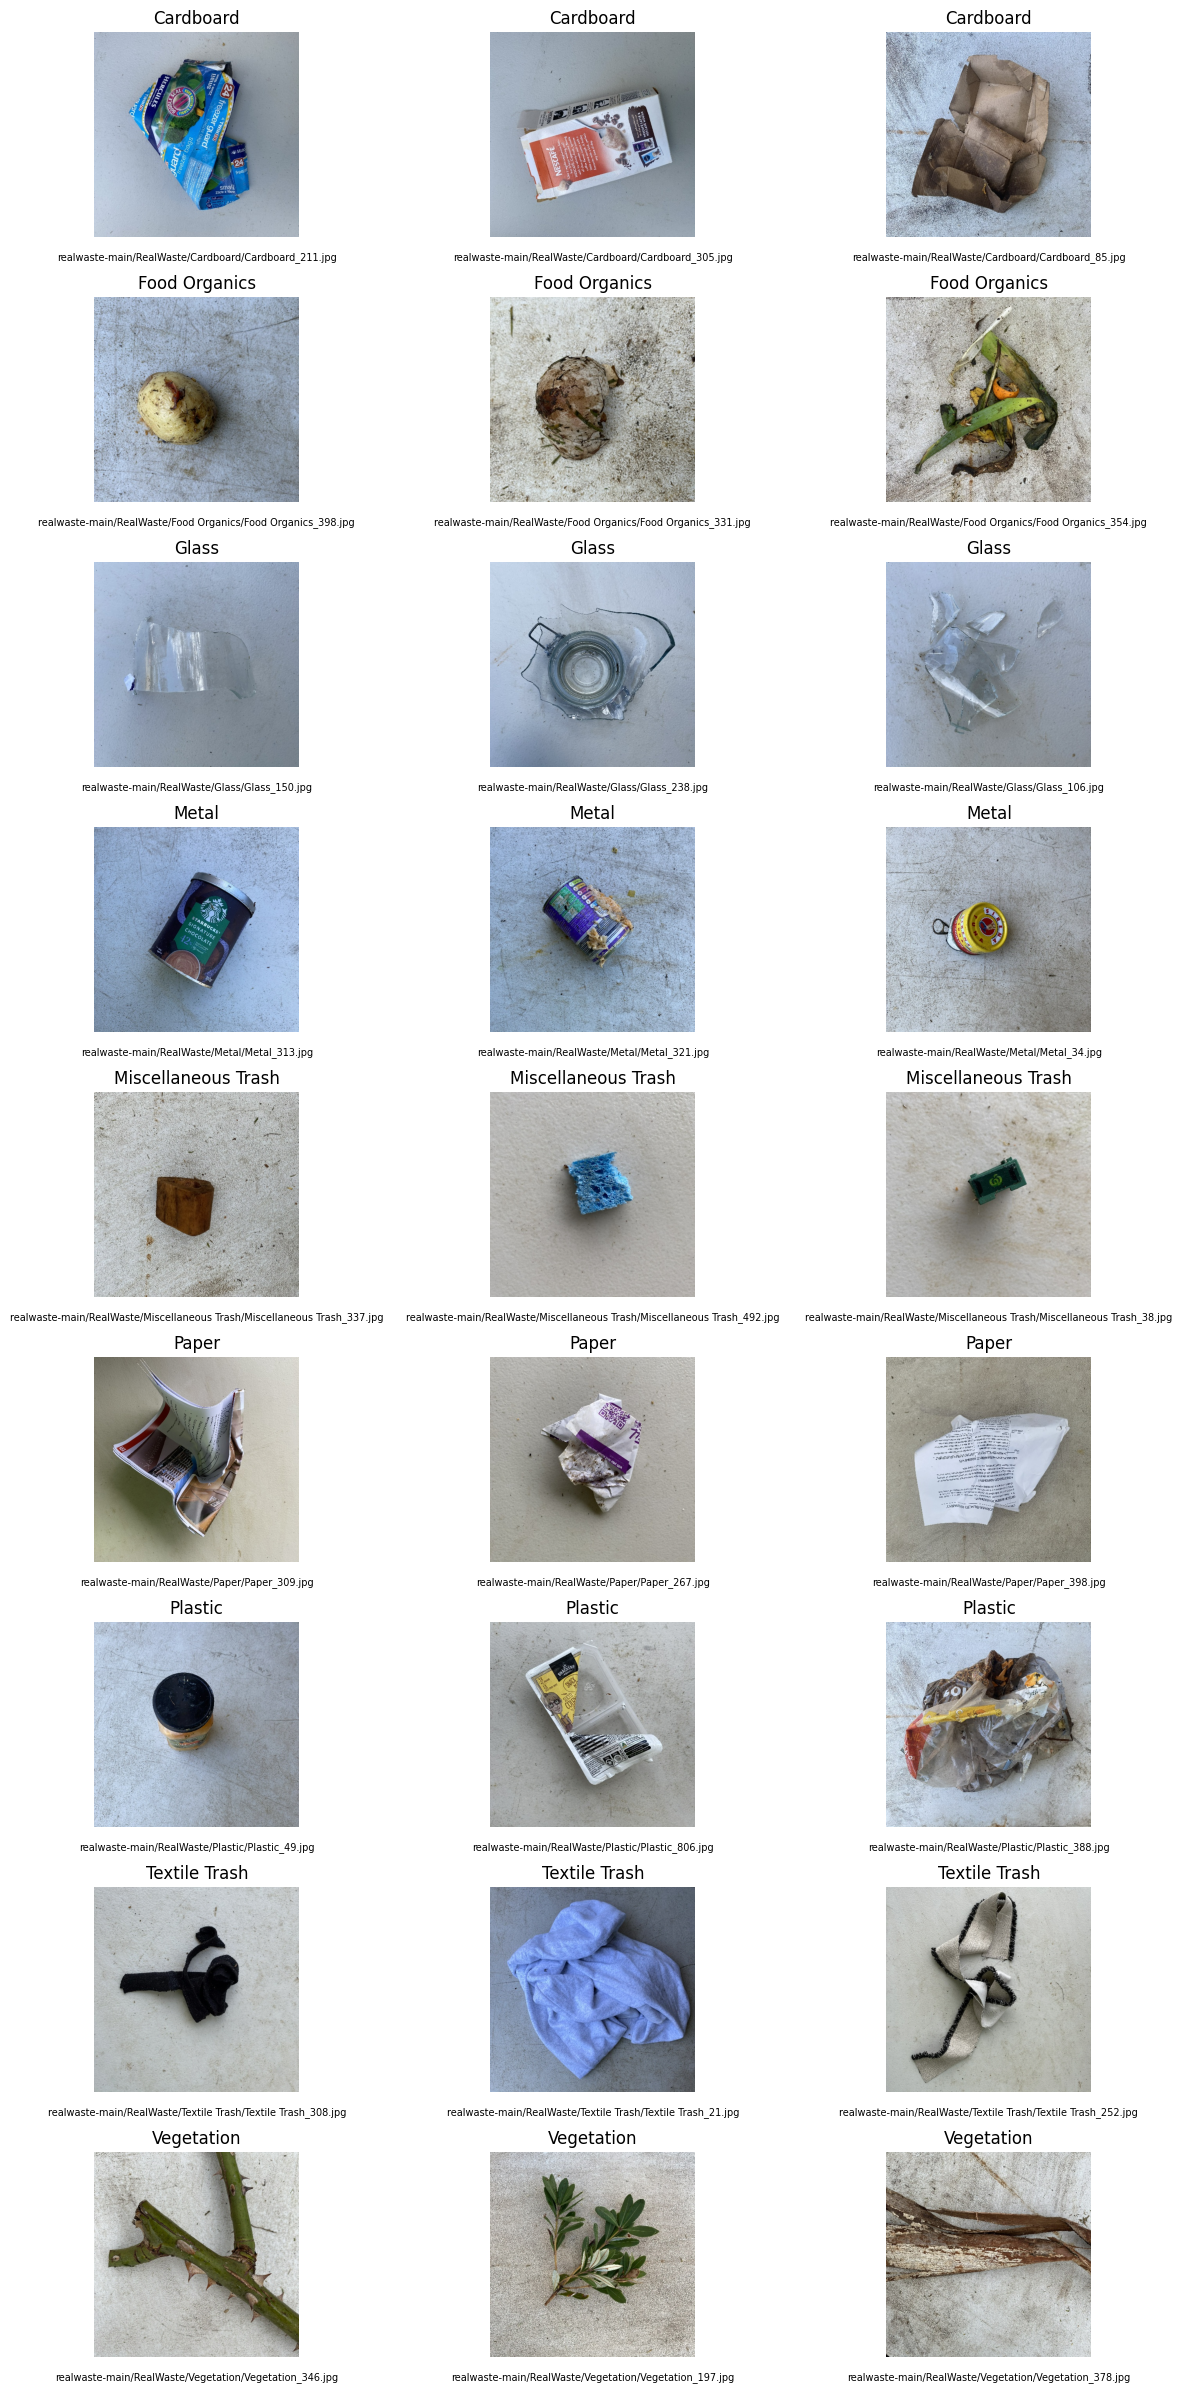

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# defining the current directory if not already defined
current_dir = os.getcwd()

# setting the path to different image folders, so that it is possible to inspect images from different classes at the same time (at random)
image_folders = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

# setting the number of images to inspect
num_images = 3

# setting the size of the plot
plt.figure(figsize=(12, 24))

# iterating over the image folders
for i, image_folder in enumerate(image_folders):
    # setting the path to the image folder
    folder_path = os.path.join(current_dir, f'realwaste-main/RealWaste/{image_folder}')
    
    # getting the list of images in the folder
    images = os.listdir(folder_path)
    
    # randomly selecting images
    selected_images = np.random.choice(images, num_images)
    
    # iterating over the selected images
    for j, selected_image in enumerate(selected_images):
        # setting the path to the image
        image_path = os.path.join(folder_path, selected_image)
        
        # loading the image
        image = Image.open(image_path)
        
        # adding the image to the plot
        plt.subplot(len(image_folders), num_images, i * num_images + j + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{image_folder}')
        
        # adding the relative image path below the image
        relative_path = os.path.relpath(image_path, current_dir)
        plt.text(0.5, -0.1, relative_path, ha='center', va='center', transform=plt.gca().transAxes, fontsize=7)

# displaying the plot
plt.tight_layout()
plt.show()

The images doesnt seem to contain any noise, meaning that at a first inspection no images seem to have been mislabeled. Please note, that although this isnt a very large data set, it can be quite difficult to inspect every image and its label. What could be seen as food organics could also be seen as vegetation, and what could be seen as plastic could be glass. 

In terms of ambiguity, one should pay attention to certain classes. The class of 'Miscellaneous Trash' could lead to either noise or ambiguity, as the definition of miscellaneous is "consisting of members or elements of different kinds; of mixed character" (https://www.dictionary.com/browse/miscellaneous#google_vignette), meaning that an image put in this class could also belong in another, dependning of what the "mixed character" consists of. The class of plastic could also be containing elements which in itself could be classified as food organiscs, and the class of textile could contain elements of plastic through buttons or metal through zippers. 

Concerning the aspect of rare features, it is important to look at the distribution of the classes, where 'Textile Trash' has the lowest image count at 318 images, while 'Plastic' has the highest representation at 921 images (note, that this doesnt fit with the numbers presented in the article). It would be good to keep this in mind, as it could have influence on the model (overfitting??).

In [ ]:
# XXXX PRACTICE TASK, NOT A PART OF ADW XXXX
# Display a few examples of images from the dataset that you think are noisy, ambiguous, rare, and/or redundant
## maybe use the above, where i can see the relative path to the image?? 

# Discuss the best way to handle the selected images

### b. Read the paper by Single er al. (2023). Focus on what you would need to know to replicate their approach. For instance: Which models do they train? What’s the learning rate? Which kind of data augmentation do they use? How well do their models perform?

### c. Go through as many points on the universal workflow of machine learning in CH6 as you find relevant (e.g., skip deployment, i.e., CH6.3). Use the same training/validation procedure and split as in Single et al. (2023), but do not make a separate test set. A separate test set will be provided at the exam.

#### Define the task 

- The problem we are trying to solve is the accurate classification of landfill waste to contribute to efficient waste management practices
- This will be done with the RealWaste dataset, which contains 4752 images disstributed across 9 classes/labels
- The data set was collected from the Whyte’s GullyWaste and Resource Recovery Centre’s landfill site located in Wollongong, New South Wales, Australia
- We are facing a multiclass, single label classification task, meaning that we wish to classify images to the correct label (type of waste) using prediction
- The RealWaste data set was created as a real world example to the types of waste one would find in a landfill, as compared to the data in the DiversionNet data set, which is a collection of images of waste in their "pristine" form
- The aim with having the RealWaste data set be comprised of images of waste from landfills is that it would hopefully represent the reality better, as waste rarely is in an unadultered, pristine form, but more often in a mixed, battered, or lacking shape

- Luckily, when downloading the data, not much preprocessing is needed, as all classes have their own subdirectory in the main directory
- Assigning labels is therefore not an issue, one just have to follow what has already been prepared, although, inspecting the images for mislabelling can be advised, as the risk of e.g. a cardboard being classified as paper (as mentioned in the article) is present
- If wouldnt necessarily take an expert to classify or spot mistakes in these images, but certain labels such as the Miscellaneous Trash can be difficult due to the nature of the class being, that it is comprised of waste not fitting into other classes


#### Develop a model

### d. Build and train a convnet from scratch (CH 8.2 and 9.3). Save your best model such that you can use it for inference on new images if given a new image at the exam. Also save the best model’s training and validation plots. Keep detailed notes about why you build your model the way you did. Compare your model’s performance to Single et al. (2023).

In [ ]:
# loading data and splitting into train and validation sets

# loading libraries
import os # for interacting with the file system
import shutil # for copying files
import pathlib # for working with paths

# defining the original directory
original_dir = pathlib.Path("realwaste-main/RealWaste") # setting the path to the dataset

# getting the list of subdirectories
subdirectories = [subdir for subdir in os.listdir(original_dir) if os.path.isdir(original_dir / subdir)] # getting the list of subdirectories in the original directory 

# defining the new base directory for the subsets
new_base_dir = pathlib.Path("realwaste_subset") # setting the path to the new base directory

# defining the proportions for splitting
train_proportion = 0.8 # setting the proportion of images for training
validation_proportion = 0.2 # setting the proportion of images for validation

# iterating over each subdirectory
for subdir in subdirectories: # 
    # getting the list of image files in the current subdirectory
    image_files = [file for file in os.listdir(original_dir / subdir) if file.endswith('.jpg')]
    
    # calculating the number of images for training and validation
    num_images = len(image_files) # calculating the total number of images
    train_count = int(num_images * train_proportion) # calculating the number of images for training
    validation_count = num_images - train_count # calculating the number of images for validation
    
    # calculating the start and end indices for training and validation
    train_start_index = 0 # setting the start index for training to 0
    train_end_index = train_count # setting the end index for training to the training count
    validation_start_index = train_count # setting the start index for validation to the training count
    validation_end_index = num_images # setting the end index for validation to the total number of images
    
    # creating the directory for train and validation subsets
    train_dir = new_base_dir / "train" / subdir # setting the path to the train subset
    validation_dir = new_base_dir / "validation" / subdir # setting the path to the validation subset
    os.makedirs(train_dir, exist_ok=True) # creating the directory for the train subset
    os.makedirs(validation_dir, exist_ok=True) # creating the directory for the validation subset
    
    # copying images to train subset
    for image_file in image_files[train_start_index:train_end_index]: # iterating over the images for training
        src_path = original_dir / subdir / image_file # setting the source path
        dst_path = train_dir / image_file # setting the destination path
        shutil.copy(src_path, dst_path) # copying the image to the train subset
    
    # copying images to validation subset
    for image_file in image_files[validation_start_index:validation_end_index]: # iterating over the images for validation
        src_path = original_dir / subdir / image_file # setting the source path
        dst_path = validation_dir / image_file # setting the destination path
        shutil.copy(src_path, dst_path) # copying the image to the validation subset
    
    # printing the subdirectory and the start and end indices for training and validation
    print(f"Subdirectory: {subdir}") # printing the subdirectory
    print("Train Subset: Start Index:", train_start_index, "End Index:", train_end_index) # printing the start and end indices for training
    print("Validation Subset: Start Index:", validation_start_index, "End Index:", validation_end_index) # printing the start and end indices for validation


In [ ]:
# creating the train and validation datasets

# importing image_dataset_from_directory from tensorflow.keras.utils
from tensorflow.keras.utils import image_dataset_from_directory

# creating the train dataset
train_dataset = image_dataset_from_directory( # defining the train dataset 
    new_base_dir / "train", # defining the directory as the train directory
    image_size=(524, 524), # defining the image size as 524x524 pixels (since the model expects this size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used)

validation_dataset = image_dataset_from_directory( # creating the validation dataset
    new_base_dir / "validation", # defining the directory as the validation directory
    image_size=(524, 524), # defining the image size as 524x524 pixels (since the model expects this size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used)

# Found 3798 files belonging to 9 classes
# Found 954 files belonging to 9 classes
# This output indicates that the train dataset contains 3798 files belonging to 9 classes, and the validation dataset contains 954 files belonging to 9 classes

In [ ]:
# inspecting the data and label batch shapes
for data_batch, labels_batch in train_dataset: # iterating over the train dataset
    print("data batch shape:", data_batch.shape) # printing the shape of the data batch
    print("labels batch shape:", labels_batch.shape) # printing the shape of the labels batch
    break # breaking the loop
# the data batch shape is (32, 524, 524, 3) which means that the data batch is a 4D tensor with 32 samples, each sample has a shape of 524x524 pixels with 3 channels
# the labels batch shape is (32,) which means that the labels batch is a 1D tensor with 32 elements

In [ ]:
# one-hot encoding the labels

# loading libraries
import tensorflow as tf # for deep learning

# one-hot encoding the train and validation labels
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the train labels
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the validation labels

#### - The small convnet

Running a small convnet model makes sense, to gain a better understanding of the dataset and the model's performance without adding too much complexity


In [ ]:
# instantiating the small convnet

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model
inputs = keras.Input(shape=(524, 524, 3)) # defining the input shape based on the image dimensions and the number of channels (3 for RGB)
x = layers.Rescaling(1./255)(inputs) # rescaling the input values to be between 0 and 1 since the pixel values are between 0 and 255
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) # defining the convolutional layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.Flatten()(x) # flattening the output
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer, specifying the number of Dense layers to match the number of classes, which is 9, and using the softmax activation function, which is commonly used for multi-class classification
model = keras.Model(inputs=inputs, outputs=outputs) # creating the model

In [ ]:
# displaying model summary
model.summary()

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
] 

In [ ]:
# training the model
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

"These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 60%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds."

In [ ]:
# HERE, SOMETHING ABOUT LOADING THE MODEL IN ORDER TO EVALUATE IT ON THE TEST SET???
#test_model = keras.models.load_model("convnet_from_scratch.keras")
#test_loss, test_acc = test_model.evaluate(test_dataset)
#print(f"Test accuracy: {test_acc:.3f}")

"We get a test accuracy of 69.5 (XXX)%. (Due to the randomness of neural network initializations, you may get numbers within one percentage point of that.) Because we have relatively few training samples (2,000), overfitting will be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep learning models: data augmentation."

#### - The convnet with data augmentation

"Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that, at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data so it can generalize better."

In [ ]:
# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
# displaying random augmented images

# setting the size of the plot
plt.figure(figsize=(10, 10)) # creating a new figure

# creating for loop to show augmented images
for images, _ in train_dataset.take(1): # iterating over the train dataset
    for i in range(9): # iterating over the first 9 images
        augmented_images = data_augmentation(images) # augmenting the images
        ax = plt.subplot(3, 3, i + 1) # creating a subplot (meant to show 3x3 images)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # showing the augmented images
        plt.axis("off") # turning off the axis (meaning that the axis will not be displayed)
# The images are augmented with random horizontal flip, random rotation and random zoom

"If we train a new model using this data-augmentation configuration, the model will never see the same input twice. But the inputs it sees are still heavily intercorrelated because they come from a small number of original images—we can’t produce new information; we can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, we’ll also add a Dropout layer to our model right before the densely connected classifier."

In [ ]:
# instantiating the convnet with data augmentation

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model with data augmentation
inputs = keras.Input(shape=(524, 524, 3)) # defining defining the input shape based on the image dimensions and the number of channels (3 for RGB)
x = data_augmentation(inputs) # augmenting the input
x = layers.Rescaling(1./255)(x) # rescaling the input values to be between 0 and 1 since the pixel values are between 0 and 255
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) # defining the convolutional layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # defining the convolutional layer based on the previous layer
x = layers.Flatten()(x) # flattening the output
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer, specifying the number of classes to be 9 (the number of classes in the dataset), and using softmax since it is a multi-class, single-label classification problem
model = keras.Model(inputs=inputs, outputs=outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch_with_augmentation.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

"Because we expect overfitting to occur much later during training, we will train for three times as many epochs — one hundred."

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=100, # using 100 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

"Thanks to data augmentation and dropout, we start overfitting much later, around epochs 60–70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range — a big improvement over our first try."

In [ ]:
# HERE, SOMETHING ABOUT LOADING THE MODEL IN ORDER TO EVALUATE IT ON THE TEST SET???
#test_model = keras.models.load_model(
#"convnet_from_scratch_with_augmentation.keras")
#test_loss, test_acc = test_model.evaluate(test_dataset)
#print(f"Test accuracy: {test_acc:.3f}")

"We get a test accuracy of 83.5 (XXXX)%. It’s starting to look good!"

#### - The convnet with residual connections - TOO BIG TO RUN??

"If your function chain is too deep, this noise starts overwhelming gradient information, and backpropagation stops working. Your model won’t train at all. This is the vanishing gradients problem. The fix is simple: just force each function in the chain to be nondestructive—to retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a residual connection. It’s dead easy: just add the input of a layer or block of layers back to its output (see figure 9.9). The residual connection acts as an information shortcut around destructive or noisy blocks (such as blocks that contain relu activations or dropout layers), enabling error gradient information from early layers to propagate noiselessly through a deep network."

In [ ]:
# instantiating the convnet with residual connections

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model with residual connections
inputs = keras.Input(shape=(524, 524, 3)) # specifying the input shape of the model as 524x524 pixels with 3 channels
x = layers.Rescaling(1./255)(inputs) # rescaling the input data to be between 0 and 1
x = layers.Conv2D(filters=64, kernel_size=7, activation="relu")(x) # adding a convolutional layer with 64 filters, a filter size of 7x7 and relu activation function (to capture more complex patterns since the images are high-resolution)

def residual_block(x, filters, pooling=False): # defining a function called residual_block that takes in the input x, the number of filters and a pooling parameter which is set to False by default
    residual = x # saving the input in a variable called residual
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x) # adding a convolutional layer with the specified number of filters, a filter size of 3x3, relu activation function and same padding
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x) # adding another convolutional layer with the specified number of filters, a filter size of 3x3, relu activation function and same padding
    if pooling: # if the pooling parameter is True
        x = layers.MaxPooling2D(2, padding="same")(x) # add a max pooling layer with a pool size of 2x2
        residual = layers.Conv2D(filters, 1, strides=2)(residual) # add a convolutional layer with the specified number of filters, a filter size of 1x1 and a stride of 2 to the residual variable
    elif filters != residual.shape[-1]: # if the number of filters is not equal to the number of channels in the residual variable
        residual = layers.Conv2D(filters, 1)(residual) # add a convolutional layer with the specified number of filters and a filter size of 1x1 to the residual variable
    x = layers.add([x, residual]) # add the output of the second convolutional layer and the residual variable
    return x # returning the output

# adding residual blocks with larger number of filters to capture more complex patterns in the images (which have a high input size)
x = residual_block(x, filters=128, pooling=False) # adding a residual block with 128 filters and no pooling layer, since we want to delay pooling to allow the network to capture more fine-grained features before reducing spatial dimensions
x = residual_block(x, filters=256, pooling=True) # adding a residual block with 256 filters and a pooling layer, since we want the network to progressively reduce the spatial dimensions of the feature maps, enabling the model to capture higher-level features with larger receptive fields
x = residual_block(x, filters=512, pooling=False) # adding a residual block with 512 filters and no pooling layer, since we want to capture a more detailed representation of the spatial information before performing the global pooling operation

x = layers.GlobalAveragePooling2D()(x) # adding a global average pooling layer
outputs = layers.Dense(9, activation="softmax")(x) # adding a dense layer with 9 unit (one for each class) and softmax activation function (since it is a multi-class, single-label classification problem)
model = keras.Model(inputs=inputs, outputs=outputs) # creating a model with the specified inputs and outputs

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch_with_residual_connections.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

#### - The convnet with batch normalization

"Normalization is a broad category of methods that seek to make different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data."

"Previous examples in this book normalized data before feeding it into models. But data normalization may be of interest after every transformation operated by the network: even if the data entering a Dense or Conv2D network has a 0 mean and unit variance, there’s no reason to expect a priori that this will be the case for the data coming out. Could normalizing intermediate activations help? Batch normalization does just that. It’s a type of layer (BatchNormalization in Keras) introduced in 2015 by Ioffe and Szegedy;2 it can adaptively normalize data even as the mean and variance change over time during training. During training, it uses the mean and variance of the current batch of data to normalize samples, and during inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training."

"The main effect of batch normalization appears to be that it helps with gradient propagation—much like residual connections—and thus allows for deeper networks. Some very deep networks can only be trained if they include multiple BatchNormalization layers."

In [ ]:
# instantiating the convnet with batch normalization

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model with batch normalization
# instantiating the small convnet

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model
inputs = keras.Input(shape=(524, 524, 3)) # defining the input shape based on the image dimensions and the number of channels (3 for RGB)
x = layers.Rescaling(1./255)(inputs) # rescaling the input values to be between 0 and 1 since the pixel values are between 0 and 255
x = layers.Conv2D(filters=32, kernel_size=3, use_bias=False)(x) # defining the convolutional layer with use_bias=False
x = layers.BatchNormalization()(x) # Batch normalization layer added
x = layers.Activation("relu")(x) # ReLU activation added
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer
x = layers.Conv2D(filters=64, kernel_size=3, use_bias=False)(x) # defining the convolutional layer based on the previous layer with use_bias=False
x = layers.BatchNormalization()(x) # Batch normalization layer added
x = layers.Activation("relu")(x) # ReLU activation added
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer 
x = layers.Conv2D(filters=128, kernel_size=3, use_bias=False)(x) # defining the convolutional layer based on the previous layer with use_bias=False
x = layers.BatchNormalization()(x) # Batch normalization layer added
x = layers.Activation("relu")(x) # ReLU activation added
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x) # defining the convolutional layer based on the previous layer with use_bias=False
x = layers.BatchNormalization()(x) # Batch normalization layer added
x = layers.Activation("relu")(x) # ReLU activation added
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x) # defining the convolutional layer based on the previous layer with use_bias=False
x = layers.BatchNormalization()(x) # Batch normalization layer added
x = layers.Activation("relu")(x) # ReLU activation added
x = layers.Flatten()(x) # flattening the output
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer, specifying the number of Dense layers to match the number of classes, which is 9, and using the softmax activation function, which is commonly used for multi-class classification
model = keras.Model(inputs=inputs, outputs=outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch_with_batch_normalization.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

#### - The convnet with depthwise separable convolutions

"What if I told you that there’s a layer you can use as a drop-in replacement for Conv2D that will make your model smaller (fewer trainable weight parameters) and leaner (fewer floating-point operations) and cause it to perform a few percentage points better on its task? That is precisely what the depthwise separable convolution layer does (SeparableConv2D in Keras). This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution)"

"Depthwise separable convolution requires significantly fewer parameters and involves fewer computations compared to regular convolution, while having comparable representational power. It results in smaller models that converge faster and are less prone to overfitting. These advantages become especially important when you’re training small models from scratch on limited data."

In [ ]:
# instantiating the convnet with depthwise separable convolutions

# loading libraries
from tensorflow import keras
from tensorflow.keras import layers

# defining the model
inputs = keras.Input(shape=(524, 524, 3)) # defining the input shape based on the image dimensions and the number of channels (3 for RGB)
x = layers.Rescaling(1./255)(inputs) # rescaling the input values to be between 0 and 1 since the pixel values are between 0 and 255

# depthwise separable convolution layers
x = layers.SeparableConv2D(filters=32, kernel_size=3, activation="relu")(x) # depthwise separable convolutional layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer
x = layers.SeparableConv2D(filters=64, kernel_size=3, activation="relu")(x) # depthwise separable convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer 
x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu")(x) # depthwise separable convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x) # depthwise separable convolutional layer based on the previous layer
x = layers.MaxPooling2D(pool_size=2)(x) # defining the max pooling layer based on the previous layer
x = layers.SeparableConv2D(filters=256, kernel_size=3, activation="relu")(x) # depthwise separable convolutional layer based on the previous layer

x = layers.Flatten()(x) # flattening the output
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer, specifying the number of Dense layers to match the number of classes, which is 9, and using the softmax activation function, which is commonly used for multi-class classification
model = keras.Model(inputs=inputs, outputs=outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch_with_depthwise_separable_convolutions.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

#### - The mini Xception-like model

Bringing all the convnet ideas together:

" 

- Your model should be organized into repeated blocks of layers, usually made of multiple convolution layers and a max pooling layer.
- The number of filters in your layers should increase as the size of the spatial feature maps decreases.
- Deep and narrow is better than broad and shallow.
- Introducing residual connections around blocks of layers helps you train deeper networks.
- It can be beneficial to introduce batch normalization layers after your convolution layers.
- It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.

"

In [ ]:
# defining the data augmentation stage

# loading libraries
from tensorflow import keras
from keras import layers

# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
inputs = keras.Input(shape=(524, 524, 3)) # specifying the input shape of the model as 524x524
x = data_augmentation(inputs) # adding the data augmentation layer

x = layers.Rescaling(1./255)(x) # rescaling the input data to be between 0 and 1
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) # adding a convolutional layer with 32 filters of size 5x5 and no bias

for size in [32, 64, 128, 256, 512]: # looping through the sizes
    residual = x # saving the input in a variable called residual

    x = layers.BatchNormalization()(x) # adding a batch normalization layer
    x = layers.Activation("relu")(x) # adding a relu activation layer
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # adding a separable convolutional layer with the specified number of filters, a filter size of 3x3, same padding and no bias

    x = layers.BatchNormalization()(x) # adding a batch normalization layer
    x = layers.Activation("relu")(x) # adding a relu activation layer
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # adding another separable convolutional layer with the specified number of filters, a filter size of 3x3, same padding and no bias

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # adding a max pooling layer with a pool size of 3x3, a stride of 2 and same padding

    residual = layers.Conv2D( # adding a convolutional layer to the residual variable
        size, 1, strides=2, padding="same", use_bias=False)(residual) # with the specified number of filters, a filter size of 1x1, a stride of 2, same padding and no bias
    x = layers.add([x, residual]) # adding the output of the max pooling layer and the residual variable

x = layers.GlobalAveragePooling2D()(x) # adding a global average pooling layer
x = layers.Dropout(0.5)(x) # adding a dropout layer with a rate of 0.5
outputs = layers.Dense(9, activation="softmax")(x) # adding a dense layer with 9 units (one for each class) and softmax activation function
model = keras.Model(inputs=inputs, outputs=outputs) # creating a model with the specified inputs and outputs

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="convnet_from_scratch_mini_xception.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=50, # using 50 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # for plotting

# getting the accuracy, validation accuracy, loss, and validation loss
accuracy = history.history["accuracy"] # getting the accuracy
val_accuracy = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(accuracy) + 1) # getting the epochs
plt.plot(epochs, accuracy, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

### e. Build and train a pretrained model (CH 8.3). Select one of the pretrained models used by Single et al. (2023). Save your best model such that you can use it for inference on new images if given a new image at the exam. Also save the best model’s training and validation plots. Keep detailed notes about why you build your model the way you did. Compare your model’s performance to Single et al. (2023).

### - VGG16

#### - Pretrained model with feature extraction

"Feature extraction consists of using the representations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch."

"Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base."

In [ ]:
# recreating the train and validation datasets with the new image size, since the model expects 224x224 pixels

# importing image_dataset_from_directory from tensorflow.keras.utils
from tensorflow.keras.utils import image_dataset_from_directory

# creating the train dataset
train_dataset = image_dataset_from_directory( # defining the train dataset 
    new_base_dir / "train", # defining the directory as the train directory
    image_size=(224, 224), # defining the image size as 224x224 pixels (since the model expects this size) (can be set to 524x524 pixels if the model is trained on the original image size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used) (can be set to 4 as in the article)


validation_dataset = image_dataset_from_directory( # creating the validation dataset
    new_base_dir / "validation", # defining the directory as the validation directory
    image_size=(224, 224), # defining the image size as 224x224 pixels (since the model expects this size) (can be set to 524x524 pixels if the model is trained on the original image size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used) (can be set to 4 as in the article)

# Found 3798 files belonging to 9 classes
# Found 954 files belonging to 9 classes
# This output indicates that the train dataset contains 3798 files belonging to 9 classes, and the validation dataset contains 954 files belonging to 9 classes

In [ ]:
# inspecting the new data and label batch shapes
for data_batch, labels_batch in train_dataset: # iterating over the train dataset
    print("data batch shape:", data_batch.shape) # printing the shape of the data batch
    print("labels batch shape:", labels_batch.shape) # printing the shape of the labels batch
    break # breaking the loop
# the data batch shape is (32, 224, 224, 3) which means that the data batch is a 4D tensor with 32 samples, each sample has a shape of 224x224 pixels with 3 channels
# the labels batch shape is (32,) which means that the labels batch is a 1D tensor with 32 elements

In [ ]:
# one-hot encoding the labels

# loading libraries
import tensorflow as tf # for deep learning

# one-hot encoding the train and validation labels
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the train labels
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the validation labels

In [ ]:
# loading libraries
from tensorflow import keras

# instantiating the VGG16 convolutional base
conv_base = keras.applications.vgg16.VGG16( # loading the VGG16 model
    weights="imagenet", # using the imagenet weights
    include_top=False, # excluding the top layer
    input_shape=(224, 224, 3)) # defining the input shape (should be deleted if the model is trained on the original image size, or set to 524x524 pixels)

In [ ]:
conv_base.summary() # printing the model summary

"

At this point, there are two ways we could proceed:

- Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.

- Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing from end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

"

##### 1. Fast feature extraction without data augmentation

In [ ]:
# Extracting the VGG16 features and corresponding labels

import numpy as np # importing numpy as np

def get_features_and_labels(dataset): # defining a function to get the features and labels
    all_features = [] # initializing the list of all features
    all_labels = [] # initializing the list of all labels
    for images, labels in dataset: # iterating over the dataset
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # preprocessing the images
        features = conv_base.predict(preprocessed_images) # getting the features
        all_features.append(features) # appending the features
        all_labels.append(labels) # appending the labels
    return np.concatenate(all_features), np.concatenate(all_labels) # returning the features and labels

train_features, train_labels =  get_features_and_labels(train_dataset) # getting the features and labels of the train dataset
val_features, val_labels =  get_features_and_labels(validation_dataset) # getting the features and labels of the validation dataset

In [ ]:
train_features.shape # printing the shape of the train features

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# instantiating the model without data augmentation
inputs = keras.Input(shape=(7, 7, 512)) # defining the input shape (16, 16, 512 if using 524x524 input images)
x = layers.Flatten()(inputs) # flattening the input
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="feature_extraction_vgg16.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_features, train_labels, # using the train features and labels
    epochs=20, # using 20 epochs
    validation_data=(val_features, val_labels), # using the validation features and labels
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

"We reach a validation accuracy of about 97%—much better than we achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features."

"However, the plots also indicate that we’re overfitting almost from the start— despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets."

##### 2. Feature extraction together with data augmentation

In [ ]:
# instantiating and freezing the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16( # loading the VGG16 model
    weights="imagenet", # using the imagenet weights
    include_top=False) # excluding the top layer
conv_base.trainable = False # freezing the convolutional base

In [ ]:
# printing a list of the trainable weights before freezing the convolutional base
conv_base.trainable = True # unfreezing the convolutional base
print("This is the number of trainable weights " 
      "before freezing the conv base:", len(conv_base.trainable_weights)) # printing the number of trainable weights

In [ ]:
# printing a list of the trainable weights after freezing the convolutional base
conv_base.trainable = False # freezing the convolutional base
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights)) # printing the number of trainable weights

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
# instantiating the model with data augmentation 
inputs = keras.Input(shape=(224, 224, 3)) # defining the input shape (524, 524, 3 if using the original image size)
x = data_augmentation(inputs) # augmenting the input
#x = keras.applications.vgg16.preprocess_input(x) # preprocessing the input (removing this makes the model work??)
# this might be because the input is already preprocessed by the data augmentation layer?
# it could influence the performance of the model, but since it doesn't work when included, it is removed
x = conv_base(x) # adding the convolutional base
x = layers.Flatten()(x) # flattening the output
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="feature_extraction_with_data_augmentation_vgg16.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=50, # using 50 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

" We reach a validation accuracy of over 98%. This is a strong improvement over the previous model."

" We get a test accuracy of 97.5%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model’s accuracy always depends on the set of samples you evaluate it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets."

#### - Fine-tuning a pretrained model

"Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused in order to make them more relevant for the problem at hand."

"Thus the steps for fine-tuning a network are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the next chapter.)
5. Jointly train both these layers and the part we added."

In [ ]:
conv_base.summary() # printing the model summary

"We’ll fine-tune the last three convolutional layers, which means all layers up to block4_ pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable."

"Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:

- Earlier layers in the convolutional base encode more generic, reusable features, whereas layers higher up encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up, starting from where we left off in the previous example."

In [ ]:
# freezing all layers until the fourth from the last
conv_base.trainable = True # unfreezing the convolutional base
for layer in conv_base.layers[:-4]: # iterating over the layers of the convolutional base except the last 4 layers
    layer.trainable = False # freezing the layers

"Now we can begin fine-tuning the model. We’ll do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. Updates that are too large may harm these representations."

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
# instantiating the model with data augmentation 
inputs = keras.Input(shape=(224, 224, 3)) # defining the input shape (524, 524, 3 if using the original image size)
x = data_augmentation(inputs) # augmenting the input
#x = keras.applications.vgg16.preprocess_input(x) # preprocessing the input (removing this makes the model work??)
# this might be because the input is already preprocessed by the data augmentation layer?
# it could influence the performance of the model, but since it doesn't work when included, it is removed
x = conv_base(x) # adding the convolutional base
x = layers.Flatten()(x) # flattening the output
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # adding the optimizer as rmsprop with a learning rate of 1e-5 (this is a smaller learning rate than the default)
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance 

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="fine_tuning_vgg16.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

"we get a test accuracy of 98.5 (XXX)% (again, your own results may be within one percentage point)."

### - Inception V3

The best model from the article...

In [ ]:
# recreating the train and validation datasets with the new image size, since the model expects 299x299 pixels

# importing image_dataset_from_directory from tensorflow.keras.utils
from tensorflow.keras.utils import image_dataset_from_directory

# creating the train dataset
train_dataset = image_dataset_from_directory( # defining the train dataset 
    new_base_dir / "train", # defining the directory as the train directory
    image_size=(299, 299), # defining the image size as 299x299 pixels (since the model expects this size) (can be set to 524x524 pixels if the model is trained on the original image size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used) (can be set to 4 as in the article)


validation_dataset = image_dataset_from_directory( # creating the validation dataset
    new_base_dir / "validation", # defining the directory as the validation directory
    image_size=(299, 299), # defining the image size as 299x299 pixels (since the model expects this size) (can be set to 524x524 pixels if the model is trained on the original image size)
    batch_size=32) # defining the batch size as 32 (since the model will train on batches of images, and this size is commonly used) (can be set to 4 as in the article)

# Found 3798 files belonging to 9 classes
# Found 954 files belonging to 9 classes
# This output indicates that the train dataset contains 3798 files belonging to 9 classes, and the validation dataset contains 954 files belonging to 9 classes

In [ ]:
# inspecting the new data and label batch shapes
for data_batch, labels_batch in train_dataset: # iterating over the train dataset
    print("data batch shape:", data_batch.shape) # printing the shape of the data batch
    print("labels batch shape:", labels_batch.shape) # printing the shape of the labels batch
    break # breaking the loop
# the data batch shape is (32, 299, 299, 3) which means that the data batch is a 4D tensor with 32 samples, each sample has a shape of 299x299 pixels with 3 channels
# the labels batch shape is (32,) which means that the labels batch is a 1D tensor with 32 elements

In [ ]:
# one-hot encoding the labels

# loading libraries
import tensorflow as tf # for deep learning

# one-hot encoding the train and validation labels
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the train labels
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=9))) # one-hot encoding the validation labels

##### 1. Fast feature extraction without data augmentation

In [ ]:
# loading libraries
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3

# instantiating the InceptionV3 convolutional base
base_model = keras.applications.InceptionV3( # instantiating the InceptionV3 model
    include_top=False, # excluding the top layer (which is the classification layer)
    weights="imagenet", # using the pre-trained weights on ImageNet
    input_shape=(299, 299, 3)) # setting the input shape to 299x299 pixels with 3 channels (can be set to 524x524 pixels if the model is trained on the original image size)

In [ ]:
base_model.summary() # printing the model summary

In [ ]:
# Extracting the InceptionV3 features and corresponding labels

import numpy as np # importing numpy as np

def get_features_and_labels(dataset): # defining a function to get the features and labels
    all_features = [] # initializing the list of all features
    all_labels = [] # initializing the list of all labels
    for images, labels in dataset: # iterating over the dataset
        preprocessed_images = keras.applications.inception_v3.preprocess_input(images) # preprocessing the images
        features = base_model.predict(preprocessed_images) # getting the features
        all_features.append(features) # appending the features
        all_labels.append(labels) # appending the labels
    return np.concatenate(all_features), np.concatenate(all_labels) # returning the features and labels

train_features, train_labels =  get_features_and_labels(train_dataset) # getting the features and labels of the train dataset
val_features, val_labels =  get_features_and_labels(validation_dataset) # getting the features and labels of the validation dataset

In [ ]:
train_features.shape # printing the shape of the train features

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# instantiating the model without data augmentation
inputs = keras.Input(shape=(8, 8, 2048)) # defining the input shape (16, 16, 2048 if using 524x524 input images)
x = layers.Flatten()(inputs) # flattening the input
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="feature_extraction_inception_v3.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_features, train_labels, # using the train features and labels
    epochs=20, # using 20 epochs
    validation_data=(val_features, val_labels), # using the validation features and labels
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot


#### - 2. Feature extraction together with data augmentation


In [ ]:
# instantiating and freezing the InceptionV3 convolutional base
base_model.trainable = False # freezing the convolutional base

# printing a list of the trainable weights before freezing the convolutional base
base_model.trainable = True # unfreezing the convolutional base
print("This is the number of trainable weights " 
      "before freezing the base model:", len(base_model.trainable_weights)) # printing the number of trainable weights

# printing a list of the trainable weights after freezing the convolutional base
base_model.trainable = False # freezing the convolutional base
print("This is the number of trainable weights "
      "after freezing the base model:", len(base_model.trainable_weights)) # printing the number of trainable weights

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
# instantiating the model with data augmentation
inputs = keras.Input(shape=(299, 299, 3)) # defining the input shape (524, 524, 3 if using the original image size)
x = data_augmentation(inputs) # augmenting the input
#x = keras.applications.inception_v3.preprocess_input(x) # preprocessing the input (removing this makes the model work??)
# this might be because the input is already preprocessed by the data augmentation layer?
# it could influence the performance of the model, but since it doesn't work when included, it is removed
x = base_model(x) # adding the convolutional base
x = layers.Flatten()(x) # flattening the output
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer="rmsprop", # adding the optimizer as rmsprop which is a variant of gradient descent
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="feature_extraction_with_data_augmentation_inception_v3.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=50, # using 50 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot

#### - Fine-tuning a pretrained model

In [ ]:
# model summary
base_model.summary() # printing the model summary

In [ ]:
# freezing all layers until the fourth from the last
base_model.trainable = True # unfreezing the convolutional base
for layer in base_model.layers[:-4]: # iterating over the layers of the convolutional base except the last 4 layers
    layer.trainable = False # freezing the layers

In [ ]:
# loading libraries
from tensorflow import keras
from keras import layers

# defining the data augmentation stage
data_augmentation = keras.Sequential( # defining the data augmentation
    [
        layers.RandomFlip("horizontal"), # adding random horizontal flip (this will flip the image horizontally with a 50% probability)
        layers.RandomRotation(0.1), # adding random rotation (this will rotate the image by a random angle between -0.1 and 0.1 radians)
        layers.RandomZoom(0.2), # adding random zoom (this will zoom the image by a factor between 0.8 and 1.2)
    ]
)

In [ ]:
# instantiating the model with data augmentation
inputs = keras.Input(shape=(299, 299, 3)) # defining the input shape (524, 524, 3 if using the original image size)
x = data_augmentation(inputs) # augmenting the input
#x = keras.applications.inception_v3.preprocess_input(x) # preprocessing the input (removing this makes the model work??)
# this might be because the input is already preprocessed by the data augmentation layer?
# it could influence the performance of the model, but since it doesn't work when included, it is removed
x = base_model(x) # adding the convolutional base
x = layers.Flatten()(x) # flattening the output
x = layers.Dense(256)(x) # defining a dense layer
x = layers.Dropout(0.5)(x) # adding dropout
outputs = layers.Dense(9, activation="softmax")(x) # defining the output layer
model = keras.Model(inputs, outputs) # creating the model

In [ ]:
# configuring the model for training
model.compile( # compiling the model
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # adding the optimizer as rmsprop with a learning rate of 1e-5 (this is a smaller learning rate than the default)
    loss="categorical_crossentropy", # adding the loss function as categorical_crossentropy which is used for classification problems
    metrics=["accuracy"]) # adding the metrics as accuracy which is used to evaluate the model performance

In [ ]:
# using callbacks to save the best model
callbacks = [ # defining the callbacks
    keras.callbacks.ModelCheckpoint( # defining the model checkpoint callback
        filepath="fine_tuning_inception_v3.keras", # defining the file path 
        save_best_only=True, # saving the best model only
        monitor="val_loss") # monitoring the validation loss
]

In [ ]:
# training the regularized convnet
history = model.fit( # fitting the model
    train_dataset, # using the train dataset
    epochs=30, # using 30 epochs
    validation_data=validation_dataset, # using the validation dataset
    callbacks=callbacks) # using the callbacks

In [ ]:
# plotting the training and validation accuracy and loss

# loading libraries
import matplotlib.pyplot as plt # importing matplotlib.pyplot as plt

# getting the accuracy, validation accuracy, loss, and validation loss
acc = history.history["accuracy"] # getting the accuracy
val_acc = history.history["val_accuracy"] # getting the validation accuracy
loss = history.history["loss"] # getting the loss
val_loss = history.history["val_loss"] # getting the validation loss

# plotting the training and validation accuracy and loss
epochs = range(1, len(acc) + 1) # getting the epochs
plt.plot(epochs, acc, "bo", label="Training accuracy") # plotting the training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy") # plotting the validation accuracy
plt.title("Training and validation accuracy") # setting the title
plt.legend() # adding the legend
plt.figure() # creating a new figure
plt.plot(epochs, loss, "bo", label="Training loss") # plotting the training loss
plt.plot(epochs, val_loss, "b", label="Validation loss") # plotting the validation loss
plt.title("Training and validation loss") # setting the title
plt.legend() # adding the legend
plt.show() # showing the plot